In [16]:
import matplotlib.pyplot as plt
import h5py 
import numpy as np
from ml_recon.utils import image_slices


In [4]:
def espirit(X, k, r, t, c):
    """
    Derives the ESPIRiT operator.

    Arguments:
      X: Multi channel k-space data. Expected dimensions are (sx, sy, sz, nc), where (sx, sy, sz) are volumetric 
         dimensions and (nc) is the channel dimension.
      k: Parameter that determines the k-space kernel size. If X has dimensions (1, 256, 256, 8), then the kernel 
         will have dimensions (1, k, k, 8)
      r: Parameter that determines the calibration region size. If X has dimensions (1, 256, 256, 8), then the 
         calibration region will have dimensions (1, r, r, 8)
      t: Parameter that determines the rank of the auto-calibration matrix (A). Singular values below t times the
         largest singular value are set to zero.
      c: Crop threshold that determines eigenvalues "=1".
    Returns:
      maps: This is the ESPIRiT operator. It will have dimensions (sx, sy, sz, nc, nc) with (sx, sy, sz, :, idx)
            being the idx'th set of ESPIRiT maps.
    """

    sx = np.shape(X)[0]
    sy = np.shape(X)[1]
    sz = np.shape(X)[2]
    nc = np.shape(X)[3]

    sxt = (sx//2-r//2, sx//2+r//2) if (sx > 1) else (0, 1)
    syt = (sy//2-r//2, sy//2+r//2) if (sy > 1) else (0, 1)
    szt = (sz//2-r//2, sz//2+r//2) if (sz > 1) else (0, 1)

    # Extract calibration region.    
    C = X[sxt[0]:sxt[1], syt[0]:syt[1], szt[0]:szt[1], :].astype(np.complex64)

    # Construct Hankel matrix.
    p = (sx > 1) + (sy > 1) + (sz > 1)
    A = np.zeros([(r-k+1)**p, k**p * nc]).astype(np.complex64)

    idx = 0
    for xdx in range(max(1, C.shape[0] - k + 1)):
      for ydx in range(max(1, C.shape[1] - k + 1)):
        for zdx in range(max(1, C.shape[2] - k + 1)):
          # numpy handles when the indices are too big
          block = C[xdx:xdx+k, ydx:ydx+k, zdx:zdx+k, :].astype(np.complex64) 
          A[idx, :] = block.flatten()
          idx = idx + 1

    # Take the Singular Value Decomposition.
    U, S, VH = np.linalg.svd(A, full_matrices=True)
    V = VH.conj().T

    # Select kernels.
    n = np.sum(S >= t * S[0])
    V = V[:, 0:n]

    kxt = (sx//2-k//2, sx//2+k//2) if (sx > 1) else (0, 1)
    kyt = (sy//2-k//2, sy//2+k//2) if (sy > 1) else (0, 1)
    kzt = (sz//2-k//2, sz//2+k//2) if (sz > 1) else (0, 1)

    # Reshape into k-space kernel, flips it and takes the conjugate
    kernels = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    kerdims = [(sx > 1) * k + (sx == 1) * 1, (sy > 1) * k + (sy == 1) * 1, (sz > 1) * k + (sz == 1) * 1, nc]
    for idx in range(n):
        kernels[kxt[0]:kxt[1],kyt[0]:kyt[1],kzt[0]:kzt[1], :, idx] = np.reshape(V[:, idx], kerdims)

    # Take the iucfft
    axes = (0, 1, 2)
    kerimgs = np.zeros(np.append(np.shape(X), n)).astype(np.complex64)
    for idx in range(n):
        for jdx in range(nc):
            ker = kernels[::-1, ::-1, ::-1, jdx, idx].conj()
            kerimgs[:,:,:,jdx,idx] = fft(ker, axes) * np.sqrt(sx * sy * sz)/np.sqrt(k**p)

    # Take the point-wise eigenvalue decomposition and keep eigenvalues greater than c
    maps = np.zeros(np.append(np.shape(X), nc)).astype(np.complex64)
    for idx in range(0, sx):
        for jdx in range(0, sy):
            for kdx in range(0, sz):

                Gq = kerimgs[idx,jdx,kdx,:,:]

                u, s, vh = np.linalg.svd(Gq, full_matrices=True)
                for ldx in range(0, nc):
                    if (s[ldx]**2 > c):
                        maps[idx, jdx, kdx, :, ldx] = u[:, ldx]

    return maps

fft  = lambda x, ax : np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=ax), axes=ax, norm='ortho'), axes=ax) 
ifft = lambda X, ax : np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(X, axes=ax), axes=ax, norm='ortho'), axes=ax) 


In [ ]:
f = h5py.File('/home/brenden/Documents/data/simulated_subset_random_phase/train/BraTS2021_00017/BraTS2021_00017.h5')
k_space:np.ndarray = f['k_space'][:] # type: ignore
f.close()

(16, 4, 10, 240, 240)

In [13]:
maps = np.zeros_like(k_space)
for i in range(16):
    for j in range(4):
        k_for_espirit = np.transpose(np.expand_dims(k_space[i, j], 0), (3, 2, 0, 1))
        cur_maps = espirit(k_for_espirit, 6, 24, 0.001, 0.99)
        maps[i, j] = np.transpose(cur_maps[:, :, 0, :, 0], (2, 1, 0))

(<Figure size 1000x1000 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

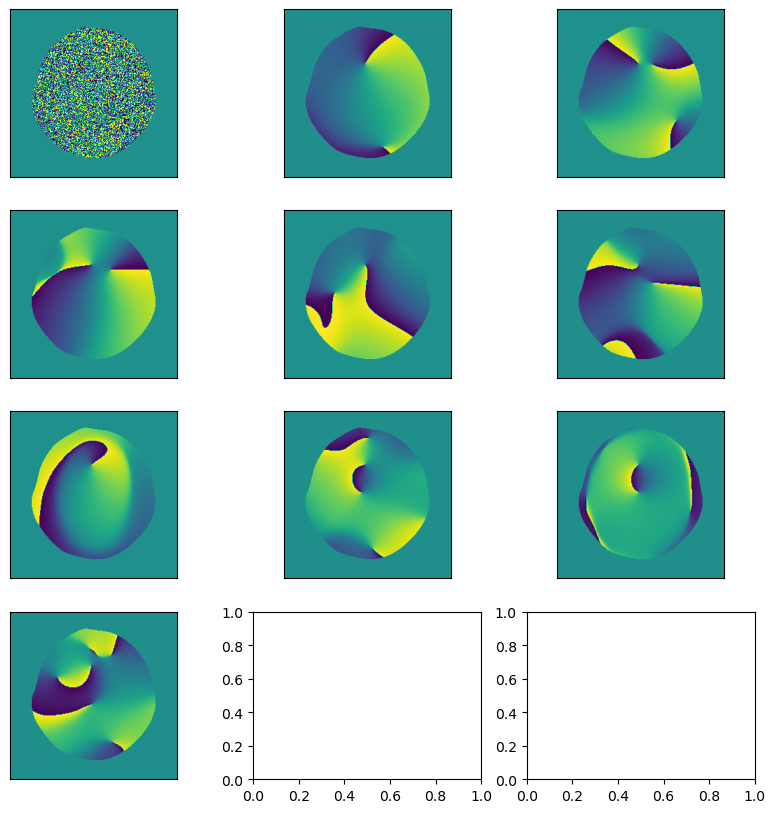

In [39]:
image_slices(np.angle(maps[10, 2]))

In [28]:
slice_map = maps[10, 1]

In [33]:
images = np.sum(ifft(k_space[10], [-1, -2]) * slice_map[None, ...].conj(), axis=1)/ (np.sum(slice_map * slice_map.conj(), axis=0, keepdims=True) + 1e-10)

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

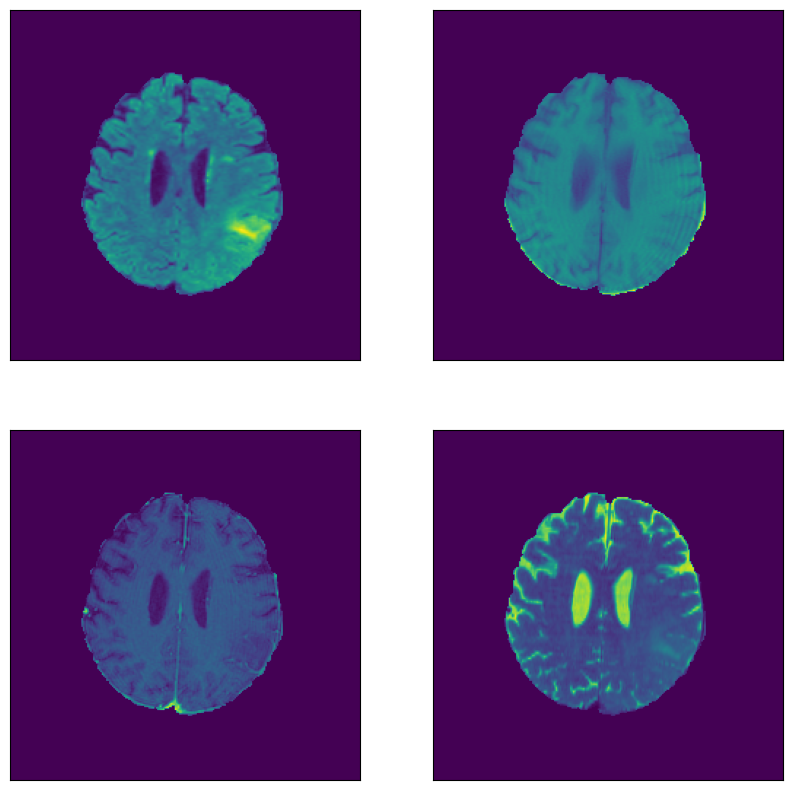

In [37]:
image_slices(np.abs(images))

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

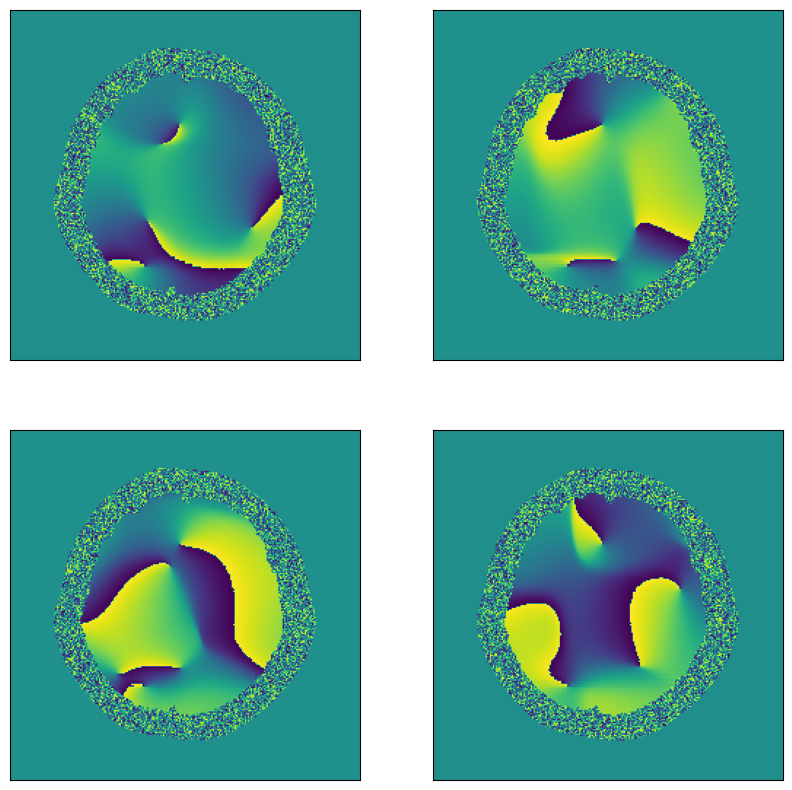

In [38]:
image_slices(np.angle(images))

In [114]:
x = np.zeros((256, 256), dtype=np.complex64)
center_x = 256 // 2
center_y = 256 // 2

x[center_x-5:center_x+5, center_y-5:center_y+5] = np.random.uniform(-1, 1, size=(10, 10)) + np.random.uniform(-1, 1, size=(10, 10))

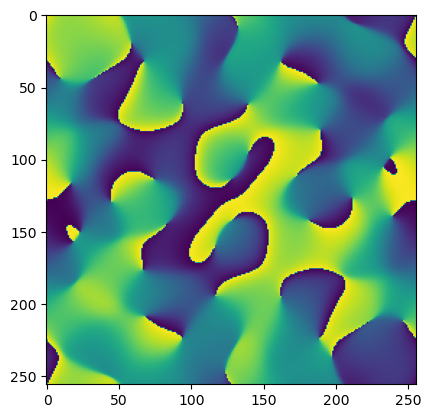

In [115]:
plt.imshow(np.angle(ifft(x, [-1, -2])))
plt.show()

In [152]:
sense = np.load('/home/brenden/Documents/data/sens2.npy')

In [153]:
sense.shape
sense = sense[:, 0, :, :]

In [154]:
sense = sense * np.exp(-1j * np.angle(sense[0, :, :]))
sense[0, :, :] = np.abs(sense[0, :, :])

(<Figure size 1000x1000 with 36 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
       dtype=object))

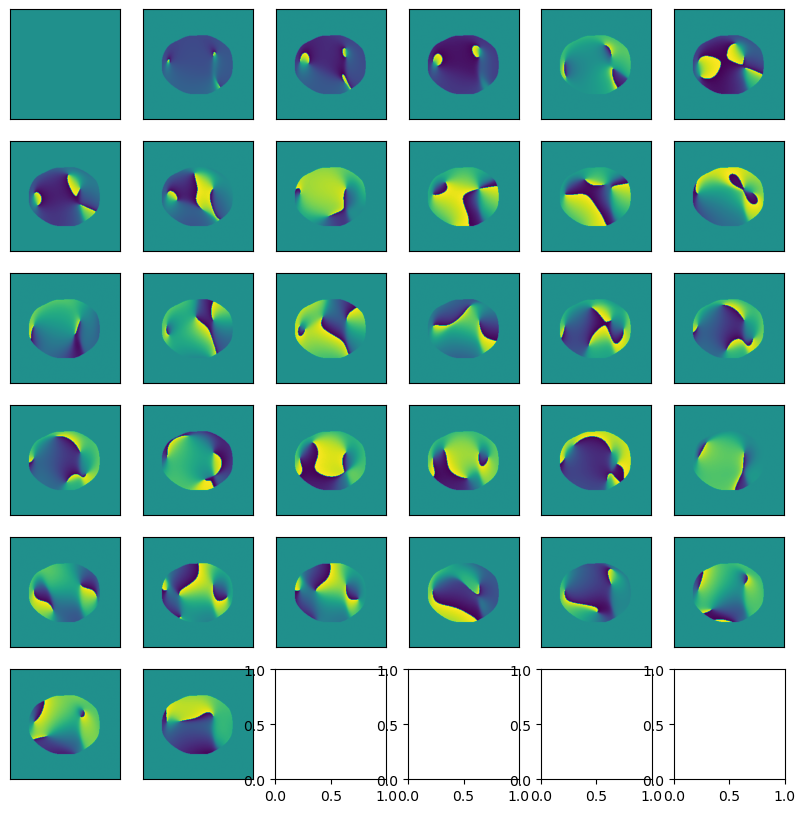

In [148]:
image_slices(np.angle(sense), vmax=3.14, vmin=-3.14)

In [155]:
sense = np.reshape(sense, (32, -1))

In [157]:
U, s, V = np.linalg.svd(sense, full_matrices=False)

In [162]:
compressed = V.reshape(32, 256, 256)

In [164]:
compressed_10 = compressed[:10, :, :]

In [172]:
compressed_10 = compressed_10 * np.exp(-1j * np.angle(compressed_10[0, :, :]))
compressed_10[0, :, :] = np.abs(compressed_10[0, :, :])

(<Figure size 1000x1000 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

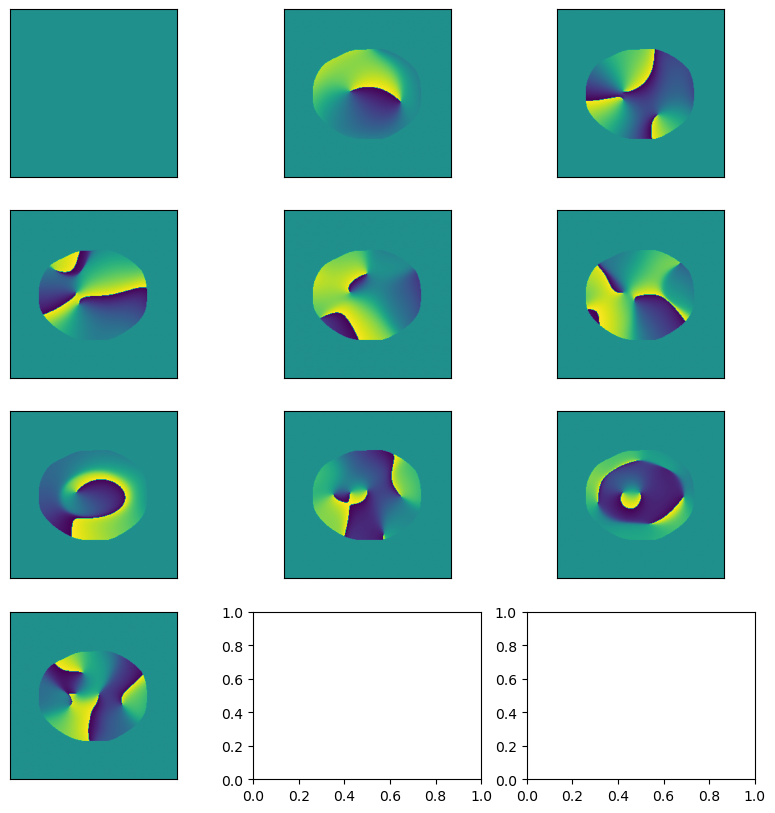

In [173]:
image_slices(np.angle(compressed_10), vmax=3.14, vmin=-3.14)

(<Figure size 1000x1000 with 12 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >]], dtype=object))

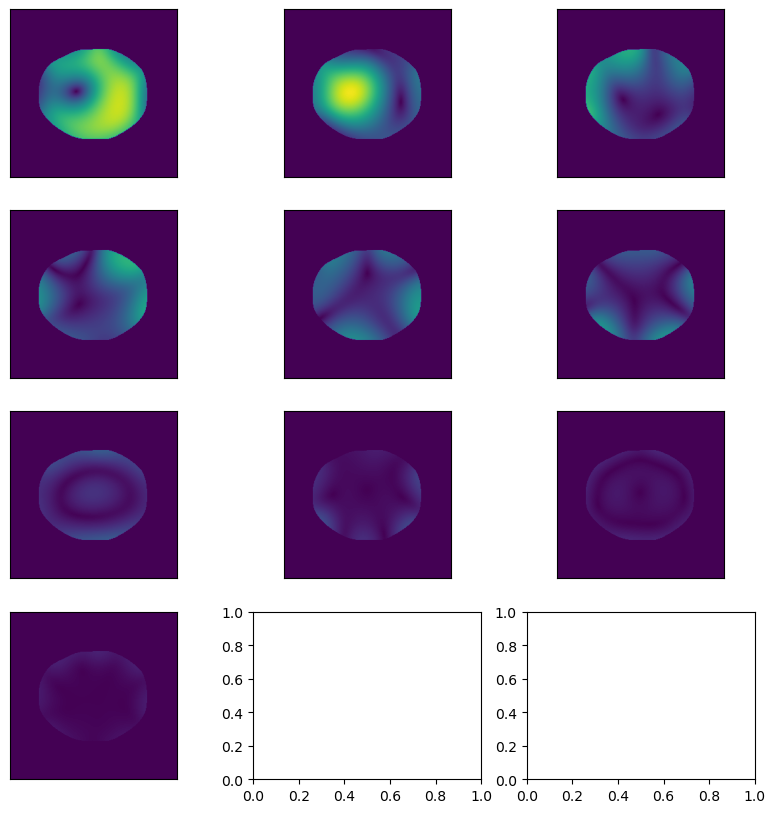

In [174]:
image_slices(np.abs(compressed_10*s[:10, None, None]), vmax=1)

In [176]:
np.save('coil_compress.npy', compressed_10*s[:10, None, None])